# Project 1:  Risk Preferences and Elicitation

In this project we will build a module to model and elicit risk preferences.  This project is broken down into a number of steps described below:

* Step 1:  Code `utility functions` defined on lottery outcomes.  
* Step 2:  Decide on, and code, a general `lottery data structure`.
* Step 3:  Code an `expected value function` and `expected utility function`.
* Step 4:  Code `complementary functions` for risk preferences. 
* Step 5:  Code a `lottery choice function`.
* Step 6:  Code the `Holt-Laury procedure` for risk preference elicitation.
* Step 7:  Code the `stepwise elicitation algorithm`.
* Step 8:  Build a `risk preference module` called `risk`.

# Step One:  Code utility functions

Research the literature starting [here](https://en.wikipedia.org/wiki/Risk_aversion) and find three additional utility functions that you can use to model risk preferences.  Build these utility functions as python functions in the cells below.  I will start you out with a simple one. 

## Functional Forms
These functional forms model the utility of money or wealth.
> Wikipedia offers a pretty good introduction to these functions

In [4]:
import math
def linear_utility(m, intercept=0, slope=1.0):
    """linear utility of money
    
        args: m, float, amount of money.
              a, float, intercept of line.
              b, float, slope of line.
              
        returns: util, float, utility of money m.    
    """
    util = intercept + slope*m
    return float(util)

def cara_utility(m,r=0.005):
    """Constant Absolute Risk Aversion"""
    import math
    util = 1 - (math.e)**(-r*m)
    return float(util)

def crra_utility(m,r=0.5):
    """Constant Relative Risk Aversion"""
    if r == 1:
        util=math.log(m)
    if r != 1:
        util=(m**(1-r)-1)/(1-r)
    return float(util)

def exponential_utility(m, a=.005):
    util = 1.0-math.e**(-a*m)
    return float(util)

def hara_utility(m, a=2, b=50):
    """Hyperbolic Absolute Risk Aversion"""
    if a == 0:
        util = exponential_utility(m, 1/b)
    elif b == 0:
        util = cara_utility(m, 1/a)
    else:
        r=1/a
        c= -b/a
        util = ((m - c)**(1-r))/(1-r)
    return float(util)

## Functions are first class citizens
In Python functions are first class citizens.  This means they can be treated the same way you treat any of the usual types of data in Python.  In particular, you can assign a function to a variable, you can pass a function to another function, and you can return a function from a function.  Here are some brief examples below.

In [6]:
m = 20
# We can assign the linear utility function to the variable utility
utility = linear_utility
print(type(utility), utility)
# we can use the linear utility function normally
print(linear_utility(m))
# or we can use the variable name instead
print(utility(m))

<class 'function'> <function linear_utility at 0x000001D435DE2160>
20.0
20.0


In [7]:
# You can also send a function to a function.
def u(m, f):
    return f(m)
m = 10
print(f"utility of {m} = {u(m, linear_utility)}")
print(f"utility of {m} = {u(m, utility)}")


utility of 10 = 10.0
utility of 10 = 10.0


Furthermore, we can put functions into data structures and use them simply by indexing them.  Here are some more examples.

In [9]:
utility_functions_list =[linear_utility, cara_utility, crra_utility, exponential_utility, hara_utility]
utility_names =["linear", "cara", "crra", "exponential", "hara"]
money_1 = 0
money_2 = 10
prob_1 = .5
prob_2 = .5
for k, u in enumerate(utility_functions_list):  
    # notice use of line break \ to split up the print statement
    print(f"utility {utility_names[k]}, expected value = {prob_1*money_1 + prob_2*money_2}, \
    expected utility = {prob_1*u(money_1) + prob_2 * u(money_2)}")

utility linear, expected value = 5.0,     expected utility = 5.0
utility cara, expected value = 5.0,     expected utility = 0.024385287749642992
utility crra, expected value = 5.0,     expected utility = 1.1622776601683795
utility exponential, expected value = 5.0,     expected utility = 0.024385287749642992
utility hara, expected value = 5.0,     expected utility = 10.916079783099615


Let's try this with a dictionary

In [11]:
# Notice I don't need a line break here
utility_functions = {"linear": linear_utility, 
                     "cara": cara_utility,
                     "crra": crra_utility,
                     "hara": hara_utility}

for key, util in utility_functions.items():
    expected_value = prob_1 * money_1 + prob_2 * money_2
    expected_utility = prob_1 * util(money_1) + prob_2 * util(money_2)
    output = f"utility {key}, expected value = {expected_value}, expected utility = {expected_utility}"
    print(output)

utility linear, expected value = 5.0, expected utility = 5.0
utility cara, expected value = 5.0, expected utility = 0.024385287749642992
utility crra, expected value = 5.0, expected utility = 1.1622776601683795
utility hara, expected value = 5.0, expected utility = 10.916079783099615


## Plotting Functions
This example uses matplotlib.  There is a notebook on this library that you can look at.

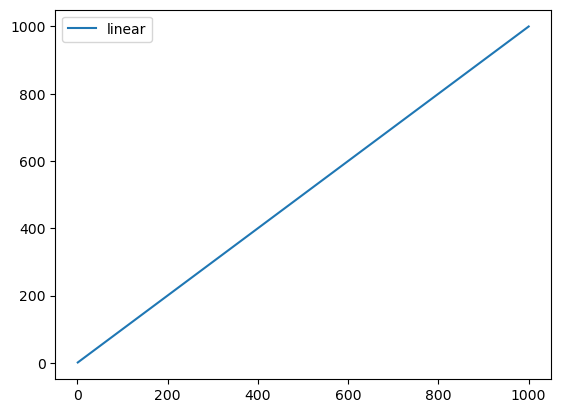

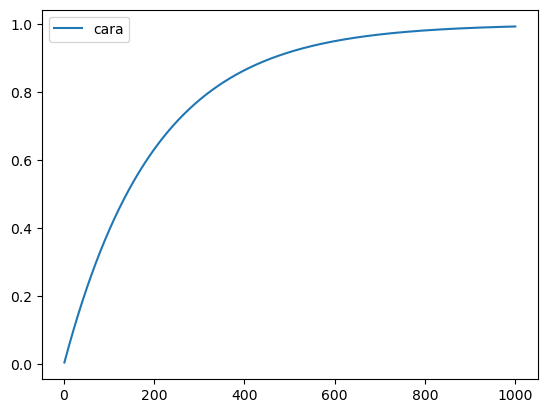

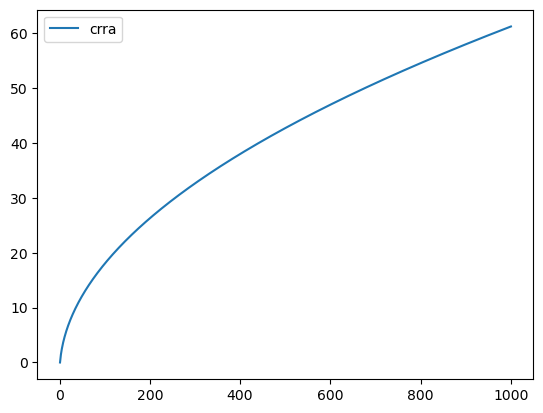

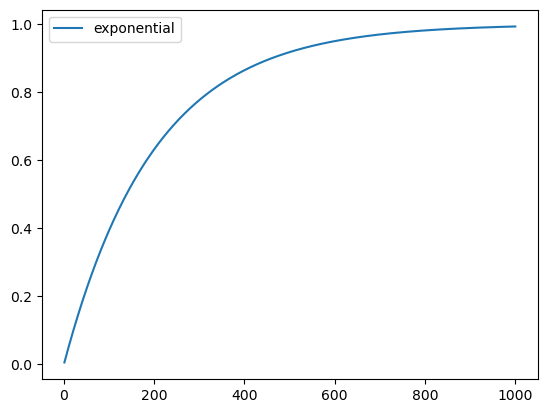

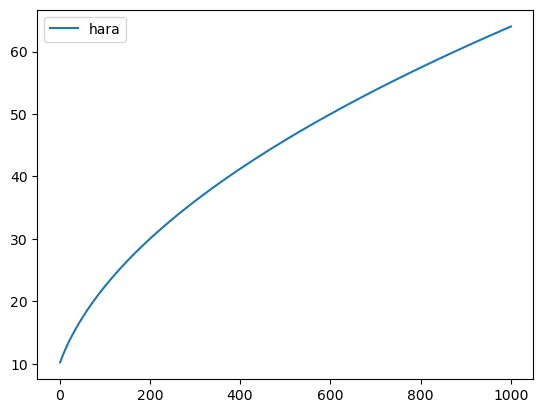

In [13]:
# Producing some standard plots
import matplotlib.pyplot as plt

def plot_utility(utility, utility_name):
    x = []
    y = []
    for i in range(1, 1001):
        x.append(i)
        y.append(utility(i))
    plt.plot(x,y)
    plt.legend([utility_name])
    plt.show(block=False)

utils =[linear_utility, cara_utility, crra_utility, exponential_utility, hara_utility]
u_names =["linear", "cara", "crra", "exponential", "hara"]
for utility, utility_name in zip(utils, u_names):
    plot_utility(utility, utility_name)

# Step Two: Design and code lottery data structure  

The simplest version of a lottery is a list of dictionaries, where each dictionary indicates an outcome and the probability, greater than or equal to 0, of that outcome happening.  Here is an example:

```python
lottery = [event_1, event_2]
lottery = [{'out':0, 'prob':0.5}, {'out':10, 'prob':0.5}]
```
Obviously the list can have as many dictionaries as we would like.  Lotteries must have the following additional property.  The sum of the probabilities across the elements (or dictionaries) of the lottery must equal 1.0.  In addition the value associate with 'out' can be either a payoff as in the example or another lottery.  When this happens we call this a compound lottery.  Here is an example.

```python
compound_lottery = [event_1, event_2]
compound_lottery = [{'out':lottery, 'prob':0.5}, {'out':10, 'prob':0.5}]
```
We will build some functions to input and build lotteries, but before we start we will build some useful helper functions.

## Helper Functions

In [16]:
import sys

def is_near_target(x, target = 0.0, precision = .001):
    """checks to see if x > target-precision and x < target+precision
    """
    if (x > target-precision and x < target+precision):
        return True
    else:
        return False

def is_lottery(lottery):
    """ returns true if lottery probabilities sum to near 1 and are all non-negative,
        lottery = [event-1, ..., event-n]
                   event-k = {"out": float_value, "prob": float_value}
    """
    total_prob = 0.0
    for event in lottery:
        if event['prob'] < 0.0: return False  #TODO fix for precision error
        total_prob += event['prob']
    if is_near_target(total_prob, target = 1, precision = .000001):
        return True
    else:
        return False

def input_number(prompt):
    """ gives user f"{prompt} or q quits:" and waits for input,
        if input is an integer then returns integer,
        if input is a float then returns float,
        if input == "q" or "Q" then exit code
    """
    need_input = True
    while (need_input):
        x = input(f"{prompt} (or q quits):")
        if x == "q" or x == "Q":
            print("User terminated session")
            sys.exit()          
        try:
            y = int(x)
            return y
        except ValueError:
            pass
        try:
            z = float(x)
            return z
        except ValueError:
            print(f"{x} is not a number")
    

## Helper Function Tests

In [18]:
#rint(input_number("enter a number"))

In [19]:
lottery = [{'out': 25.0, 'prob': 0.9553673849996607},
           {'out': 59.0, 'prob': 0.044632615000339326}]
is_lottery(lottery)

True

In [20]:
x = 1.0001
target = 1.0
print(is_near_target(x, target = target, precision = .001))
target = 1.1
print(is_near_target(x, target = target, precision = .001))


True
False


## Input a Lottery

In [22]:
def input_lottery():
    """Builds a lottery from user input
       TODO:  loop until valid lottery entered
    """
    lottery = []
    num_events= input_number("Enter number of events")
    for k in range(num_events):
        event = {}
        print(f"   Event {k+1}")
        outcome = input_number("Enter outcome")
        prob = input_number("Enter probability")
        event['out'] = outcome
        event['prob'] = prob
        lottery.append(event)
    if is_lottery(lottery):
        return lottery

#lottery = input_lottery()
#print(lottery)

## Now we can build some lottery making functions

In [24]:
import random
#help(random)

### We will start with building a single lottery

In [26]:
def print_lottery(lottery):
    """prints out a lottery in more readable form
       TODO:  only goes 2 deep
    """
    TAB = "    "
    print("Lottery")
    for k, event in enumerate(lottery):
        if type(event['out']) == list:
            print(f"event {k} prob = {event["prob"]:.3f} outcome = lottery")
            for j, subevent in enumerate(event['out']):
                print(f"{TAB}event {j} prob = {subevent["prob"]:.3f} outcome = {subevent["out"]}")
        else:
            print(f"event {k} prob = {event["prob"]:.3f} outcome = {event["out"]}")

In [27]:
def print_lottery_with_utility(lottery, u):
    """prints out a lottery in more readable form
       TODO:  only goes 2 deep
    """
    TAB = "    "
    print("Lottery")
    for k, event in enumerate(lottery):
        outcome = event['out']
        if type(outcome) == list:
            print(f"event {k} prob = {event["prob"]:.3f} outcome = lottery")
            for j, subevent in enumerate(outcome):
                subout = subevent["out"]
                print(f"{TAB}event {j} prob = {subevent["prob"]:.3f} outcome = {subout},utility = {u(subout):.4f}")
        else:
            print(f"event {k} prob = {event["prob"]:.3f} outcome = {event["out"]}, utility = {u(outcome):.4f}")

In [28]:
lottery = [{'out': 25.0, 'prob': 0.9553673849996607},
           {'out': 59.0, 'prob': 0.044632615000339326}]
print(is_lottery(lottery))
print_lottery(lottery)
print_lottery_with_utility(lottery, crra_utility)

True
Lottery
event 0 prob = 0.955 outcome = 25.0
event 1 prob = 0.045 outcome = 59.0
Lottery
event 0 prob = 0.955 outcome = 25.0, utility = 8.0000
event 1 prob = 0.045 outcome = 59.0, utility = 13.3623


In [29]:
import random

def make_simple_lottery(min_pay = 0, max_pay = 100, num_events = 2):
    """Builds a random simple lottery.
    Parms:
    min_pay, integer, lower bound on outcome,
    max_pay, integer, upper bound on outcome,
    num_events, integer, number of events in lottery

    Returns:
    lottery = [event_1, ..., event_num_events]
    event_k = {'out': pay, 'prob': probability
    """     
    lottery = []
    total_prob = 0
    upper_prob = 1.0
    for k in range(num_events-1):
        event = {}
        event['out'] = float(random.randint(min_pay, max_pay))
        prob = random.uniform(0.0, upper_prob)
        event['prob'] = prob
        upper_prob -= prob
        lottery.append(event)
    event = {}
    event['out'] = float(random.randint(min_pay, max_pay))
    event['prob'] = upper_prob
    lottery.append(event)
    if is_lottery(lottery):
        return lottery
    else:
        print("function make_simple_lottery failed to make lottery")
        make_simple_lottery()

In [30]:
lot = make_simple_lottery(num_events=5)
print_lottery(lot)

Lottery
event 0 prob = 0.236 outcome = 88.0
event 1 prob = 0.422 outcome = 68.0
event 2 prob = 0.014 outcome = 90.0
event 3 prob = 0.028 outcome = 9.0
event 4 prob = 0.300 outcome = 7.0


A compound lottery has a lottery as an outcome in an event.  The following code will take a simple lottery and make it a compound lottery.

In [32]:
def might_make_compound_lottery(lottery, min_pay = 0, max_pay = 100, num_events = 2, prob_compound_event = .5):
    """For each event in a simple lottery, turn that event's outcome into a lottery with prob_compound_event
    """
    new_lottery = [ ]
    for event in lottery:
        if random.random() <= prob_compound_event:
            lot = make_simple_lottery(min_pay = min_pay, max_pay = max_pay, num_events = num_events)
            new_event = {}
            new_event['out'] = lot
            new_event['prob'] = event['prob']
        else:
            new_event = event
        new_lottery.append(new_event)
    return new_lottery


In [33]:
lot = make_simple_lottery(num_events = 5)
print_lottery_with_utility(lot, crra_utility)
c_lot = might_make_compound_lottery(lot)
print_lottery_with_utility(c_lot, crra_utility)

Lottery
event 0 prob = 0.110 outcome = 84.0, utility = 16.3303
event 1 prob = 0.784 outcome = 25.0, utility = 8.0000
event 2 prob = 0.100 outcome = 87.0, utility = 16.6548
event 3 prob = 0.002 outcome = 16.0, utility = 6.0000
event 4 prob = 0.003 outcome = 49.0, utility = 12.0000
Lottery
event 0 prob = 0.110 outcome = lottery
    event 0 prob = 0.881 outcome = 50.0,utility = 12.1421
    event 1 prob = 0.119 outcome = 9.0,utility = 4.0000
event 1 prob = 0.784 outcome = lottery
    event 0 prob = 0.189 outcome = 23.0,utility = 7.5917
    event 1 prob = 0.811 outcome = 37.0,utility = 10.1655
event 2 prob = 0.100 outcome = lottery
    event 0 prob = 0.794 outcome = 96.0,utility = 17.5959
    event 1 prob = 0.206 outcome = 78.0,utility = 15.6635
event 3 prob = 0.002 outcome = 16.0, utility = 6.0000
event 4 prob = 0.003 outcome = 49.0, utility = 12.0000


### Building lists of lotteries

In [35]:
def print_lottery_list(lot_list):
    print("Lottery list")
    for k, lottery in enumerate(lot_list):
        print_lottery(lottery)
    print()

In [36]:
import random

def make_simple_lottery_list(num_lotteries = 2, min_pay = 0, max_pay = 100, 
                          min_events = 2, max_events = 2):
    """Builds a random list of lotteries
    
        Lottery payoffs are random draws beteen min_pay and max_pay,
        Lottery probabilities are random uniform draws that sum to one.
    
        args:
            number = int > 0, number of lotteries in list.
            payoff in [min_pay, max_pay]
            num_events in [min_events, max_events]
    """
    lottery_list = []
    for num_lot in range(num_lotteries):
        num_events = random.randint(min_events, max_events)
        lottery = make_simple_lottery(min_pay = min_pay, max_pay = max_pay, num_events = num_events)
        lottery_list.append(lottery)
       
    return lottery_list

In [37]:
lottery_list = make_simple_lottery_list(num_lotteries= 4, max_events = 4)
print_lottery_list(lottery_list)

Lottery list
Lottery
event 0 prob = 0.864 outcome = 38.0
event 1 prob = 0.136 outcome = 23.0
event 2 prob = 0.001 outcome = 4.0
Lottery
event 0 prob = 0.624 outcome = 28.0
event 1 prob = 0.220 outcome = 36.0
event 2 prob = 0.156 outcome = 72.0
Lottery
event 0 prob = 0.079 outcome = 80.0
event 1 prob = 0.921 outcome = 85.0
Lottery
event 0 prob = 0.326 outcome = 52.0
event 1 prob = 0.030 outcome = 61.0
event 2 prob = 0.085 outcome = 4.0
event 3 prob = 0.559 outcome = 52.0



In [38]:
def make_compound_lottery_list(num_lotteries = 2, 
                               min_pay = 0,
                               max_pay = 100, 
                               min_events = 2, 
                               max_events = 2,
                               prob_compound_event = .5): 
    """Builds a random list of lotteries
    
        Lottery payoffs are random draws between min_pay and max_pay,
        Lottery probabilities are random uniform draws that sum to one.
    
        args:
            number = int > 0, number of lotteries in list.
            compound = bool, if True allows compound lotteries one deep,
            negative = bool, if False min_pay = 0, if True min_pay = -max_pay.

        This works for  a  compound lottery of depth 2, i.e., a lottery with an event that is also a lottery.
        TODO: make this work for any finite depth.
    """
    lottery_list = make_simple_lottery_list(num_lotteries = num_lotteries,
                                                        min_pay = min_pay, 
                                                        max_pay = max_pay, 
                                                        min_events = min_events,
                                                        max_events = max_events)
    lot_list = []
    for lottery in lottery_list:
        num_events = random.randint(min_events, max_events)
        lot = might_make_compound_lottery(lottery, min_pay = min_pay,
                                          max_pay = max_pay, num_events = num_events,
                                          prob_compound_event = .5)
        lot_list.append(lot)
    return lot_list

In [39]:
lot_list = make_compound_lottery_list(num_lotteries = 5,
                                      min_pay = 0,
                                      max_pay = 100,
                                      min_events = 2,
                                      max_events = 4,
                                      prob_compound_event = .5)
print_lottery_list(lot_list)

Lottery list
Lottery
event 0 prob = 0.079 outcome = lottery
    event 0 prob = 0.846 outcome = 32.0
    event 1 prob = 0.126 outcome = 77.0
    event 2 prob = 0.022 outcome = 63.0
    event 3 prob = 0.006 outcome = 89.0
event 1 prob = 0.032 outcome = lottery
    event 0 prob = 0.091 outcome = 84.0
    event 1 prob = 0.614 outcome = 75.0
    event 2 prob = 0.104 outcome = 97.0
    event 3 prob = 0.191 outcome = 41.0
event 2 prob = 0.889 outcome = 17.0
Lottery
event 0 prob = 0.945 outcome = 46.0
event 1 prob = 0.032 outcome = lottery
    event 0 prob = 0.019 outcome = 2.0
    event 1 prob = 0.429 outcome = 3.0
    event 2 prob = 0.348 outcome = 28.0
    event 3 prob = 0.204 outcome = 89.0
event 2 prob = 0.023 outcome = 97.0
Lottery
event 0 prob = 0.873 outcome = lottery
    event 0 prob = 0.140 outcome = 98.0
    event 1 prob = 0.860 outcome = 21.0
event 1 prob = 0.090 outcome = lottery
    event 0 prob = 0.222 outcome = 34.0
    event 1 prob = 0.778 outcome = 51.0
event 2 prob = 0.032 o

In [40]:
import copy
def reduce_lottery(lottery):
    """ Reduces compound lottery to a simple lottery.
    
        A compound lottery has sub-lotteries as outcomes.
        A simple lottery only has payoffs as outcomes.
        
        args:
            lottery, list of dictionaries.
        returns:
            simple_lottery, list of dictionaries with no sub-lottery.
        This should work for arbitrayry depth of compound lotteies but has 
            only been tested on a depth of 2.
        TODO: Test this on arbitrary depths once compound builder can do this.
    """
    compound = True
    test_lottery = copy.deepcopy(lottery)
    while compound:
        compound = False
        new_lottery = []
        for event in test_lottery:
            if type(event['out']) == list:
                for subevent in event['out']:
                    new_event = {}
                    new_event['out'] = subevent['out']
                    if type(subevent['out']) == list: 
                        compound = True
                    new_event['prob'] = event['prob']*subevent['prob']
                    new_lottery.append(new_event)
            else:
                new_lottery.append(event)
        if compound == True: 
            test_lottery = copy.deepcopy(new_lottery)
    return new_lottery

In [41]:
lot_list = make_compound_lottery_list(num_lotteries = 5,
                                      min_pay = 0,
                                      max_pay = 100,
                                      min_events = 2,
                                      max_events = 4,
                                      prob_compound_event = .5)
print_lottery_list(lot_list)

reduced_lot_list = []
for lottery in lot_list:
    reduced_lottery = reduce_lottery(lottery)
    print(is_lottery(reduced_lottery))
    reduced_lot_list.append(reduced_lottery)

print_lottery_list(reduced_lot_list)

Lottery list
Lottery
event 0 prob = 0.487 outcome = 82.0
event 1 prob = 0.319 outcome = 57.0
event 2 prob = 0.194 outcome = 69.0
Lottery
event 0 prob = 0.496 outcome = 71.0
event 1 prob = 0.504 outcome = 17.0
Lottery
event 0 prob = 0.573 outcome = lottery
    event 0 prob = 0.759 outcome = 42.0
    event 1 prob = 0.037 outcome = 54.0
    event 2 prob = 0.203 outcome = 17.0
event 1 prob = 0.297 outcome = 49.0
event 2 prob = 0.114 outcome = 9.0
event 3 prob = 0.016 outcome = lottery
    event 0 prob = 0.943 outcome = 31.0
    event 1 prob = 0.043 outcome = 1.0
    event 2 prob = 0.014 outcome = 64.0
Lottery
event 0 prob = 0.503 outcome = lottery
    event 0 prob = 0.937 outcome = 86.0
    event 1 prob = 0.022 outcome = 39.0
    event 2 prob = 0.041 outcome = 83.0
event 1 prob = 0.494 outcome = lottery
    event 0 prob = 0.239 outcome = 19.0
    event 1 prob = 0.596 outcome = 84.0
    event 2 prob = 0.165 outcome = 85.0
event 2 prob = 0.000 outcome = lottery
    event 0 prob = 0.496 outco

## Step Three: Code an expected value function and expected utility function

### Expected Value Coded Here

In [44]:
def expected_value(lottery):
    """Calculate expected value of a lottery
    
        arg:
            lottery, list of dictioaries
        
        returns:
            ev, float, expected value of the lottery
    """
    new_lottery = reduce_lottery(lottery)
    ev = 0.0
    for node in new_lottery:
        if type(node['out']) == type([]):
            # make recursive call to evaluate sub-lottery
            ev = node['prob'] * expected_value(node['out'])
        else:
            ev = ev + node['prob'] * node['out']
    return ev

In [45]:
# Text expected value function
lottery = [{'out': 100, 'prob': 0.5}, {'out': 50, 'prob': 0.25}, {'out': 50, 'prob': 0.25}]
print(f"Expected value of {lottery} = {expected_value(lottery)}.")


Expected value of [{'out': 100, 'prob': 0.5}, {'out': 50, 'prob': 0.25}, {'out': 50, 'prob': 0.25}] = 75.0.


In [46]:
# furthermore we can use partial functions to change the parameters of linear_utility before using it
from functools import partial

m=10
print(linear_utility(m))
utility = partial(linear_utility, intercept = 1, slope = .5)
print(utility(m)) # utility is now linear_utility with new parameters


10.0
6.0


### Code Expected Utility Here

In [48]:
def expected_utility(lottery, util):
    """Calculate expected utility of a lottery
    
        arg:
            lottery, list of dictioaries containing 
                     keys, values {'prob': pr, 'outcome': out}
                         pr, float between 0.0 and 1.0 inclusive
                         out, either another lottery or a float payoff
                     
            u, utility function, returns utility of a payoff outcome
        
        returns:
            eu, float, expected utility of the lottery
    """
    eu = 0.0
    new_lottery = reduce_lottery(lottery)
    for event in new_lottery:
            eu += util(event['out'])*event['prob']
    return float(eu)

In [49]:
# Text expected utility function
lottery = [{'out': 100, 'prob': 0.5}, {'out': 50, 'prob': 0.25}, {'out': 50, 'prob': 0.25}]
print_lottery(lottery)
print(f"Expected utility = {expected_utility(lottery, crra_utility):.4f}.")


Lottery
event 0 prob = 0.500 outcome = 100
event 1 prob = 0.250 outcome = 50
event 2 prob = 0.250 outcome = 50
Expected utility = 15.0711.


In [50]:
lot_list = make_compound_lottery_list(num_lotteries = 5,
                                      min_pay = 0,
                                      max_pay = 100,
                                      min_events = 2,
                                      max_events = 4,
                                      prob_compound_event = .5)
print_lottery_list(lot_list)
util = partial(linear_utility, intercept = 0, slope = 1)
for k, lottery in enumerate(lot_list):
    print(f"Lottery {k} has ev = {expected_value(lottery):.4f} and eu = {expected_utility(lottery, util):.4f}")

Lottery list
Lottery
event 0 prob = 0.611 outcome = 51.0
event 1 prob = 0.116 outcome = lottery
    event 0 prob = 0.777 outcome = 71.0
    event 1 prob = 0.223 outcome = 27.0
event 2 prob = 0.065 outcome = lottery
    event 0 prob = 0.496 outcome = 79.0
    event 1 prob = 0.504 outcome = 90.0
event 3 prob = 0.208 outcome = 35.0
Lottery
event 0 prob = 0.052 outcome = lottery
    event 0 prob = 0.878 outcome = 23.0
    event 1 prob = 0.103 outcome = 82.0
    event 2 prob = 0.020 outcome = 76.0
event 1 prob = 0.948 outcome = 77.0
Lottery
event 0 prob = 0.107 outcome = lottery
    event 0 prob = 0.264 outcome = 29.0
    event 1 prob = 0.490 outcome = 23.0
    event 2 prob = 0.072 outcome = 9.0
    event 3 prob = 0.174 outcome = 39.0
event 1 prob = 0.279 outcome = 9.0
event 2 prob = 0.315 outcome = lottery
    event 0 prob = 0.183 outcome = 92.0
    event 1 prob = 0.756 outcome = 44.0
    event 2 prob = 0.017 outcome = 83.0
    event 3 prob = 0.044 outcome = 94.0
event 3 prob = 0.300 outco

## Step Four: complementary functions

In this step you will add two complementary functions.  The first function calculates the certainty equivalent of a simple lottery.  The second calculates the risk premium of a lottery. 

In [52]:
# first_try here
def certainty_equivalent_learn(lottery, u, min_x, max_x):
    """ Returns the certainty equivalent (ce) of a lottery.
    
        u(ce) = expected_utility(lottery, u)
        
        args:
            lottery, list of dictionaries.
            u, utility function defined over payoffs in dictionaries
        returns:
            ce, float, certainty equivalent
    """
    eu = expected_utility(lottery, u)
    print(f"expected utility = {eu}")
    # now do a bisection search for x such that u(x) = eu
    lower_bound = min_x
    upper_bound = max_x
    for k in range(6):
        u_upper = u(upper_bound)
        u_lower = u(lower_bound)
        try_this = .5*lower_bound + .5*upper_bound
        u_try = u(try_this)
        print(f"lb = {lower_bound}, try = {try_this}, ub = {upper_bound}")
        print(f" eu = {eu}, u({try_this}) = {u_try}")
        if u_try < eu:
            lower_bound = try_this
        else:
            upper_bound = try_this

In [53]:
min_pay = 0
max_pay = 100
lot =  make_simple_lottery(min_pay = 0, max_pay = 100, num_events = 5)
print_lottery(lot)

ce = certainty_equivalent_learn(lot, hara_utility, min_pay, max_pay)

Lottery
event 0 prob = 0.809 outcome = 26.0
event 1 prob = 0.173 outcome = 11.0
event 2 prob = 0.011 outcome = 97.0
event 3 prob = 0.000 outcome = 5.0
event 4 prob = 0.006 outcome = 4.0
expected utility = 13.954714375916215
lb = 0, try = 50.0, ub = 100
 eu = 13.954714375916215, u(50.0) = 17.320508075688775
lb = 0, try = 25.0, ub = 50.0
 eu = 13.954714375916215, u(25.0) = 14.142135623730951
lb = 0, try = 12.5, ub = 25.0
 eu = 13.954714375916215, u(12.5) = 12.24744871391589
lb = 12.5, try = 18.75, ub = 25.0
 eu = 13.954714375916215, u(18.75) = 13.228756555322953
lb = 18.75, try = 21.875, ub = 25.0
 eu = 13.954714375916215, u(21.875) = 13.693063937629153
lb = 21.875, try = 23.4375, ub = 25.0
 eu = 13.954714375916215, u(23.4375) = 13.919410907075054


In [54]:
# first_try here
def certainty_equivalent(lottery, u, min_x, max_x, precision = .1):
    """ Returns the certainty equivalent (ce) of a lottery.
    
        u(ce) = expected_utility(lottery, u)
        
        args:
            lottery, list of dictionaries.
            u, utility function defined over payoffs in dictionaries
        returns:
            ce, float, certainty equivalent
        TODO: only tested on linear_utility, needs to be tested with other utility functions
    """
    eu = expected_utility(lottery, u)
    print(f"expected utility = {eu:.4f}")
    # now do a bisection search for x such that u(x) = eu
    lower_bound = min_x
    upper_bound = max_x
    num_trys = 0
    while(True):
        num_trys += 1
        u_upper = u(upper_bound)
        u_lower = u(lower_bound)
        try_this = .5*lower_bound + .5*upper_bound
        u_try = u(try_this)
        #print(f"lb = {lower_bound}, try = {try_this}, ub = {upper_bound}")
        #print(f" eu = {eu}, u({try_this}) = {u_try}")
        if is_near_target(u_try, target = eu, precision = precision):
            return try_this, u_try, eu, num_trys 
        if u_try < eu:
            lower_bound = try_this
        else:
            upper_bound = try_this

In [55]:
min_pay = 0
max_pay = 1000
precision = 1
lot =  make_simple_lottery(min_pay = min_pay, max_pay = max_pay, num_events = 5)
print_lottery_with_utility(lot, hara_utility)

for k in range(5):
    precision = precision * .1
    ce, u_ce, eu, trys = certainty_equivalent(lot, hara_utility, min_pay, max_pay, precision)
    print(f"pre = {precision:.6f}, ce = {ce:.4f}, diff = {u_ce-eu:.6f}")
    print(f"ce = {ce:.4f}, u(ce) = {u_ce:.4f}, num_trys = {trys}")

Lottery
event 0 prob = 0.081 outcome = 425.0, utility = 42.4264
event 1 prob = 0.778 outcome = 960.0, utility = 62.7694
event 2 prob = 0.055 outcome = 881.0, utility = 60.1997
event 3 prob = 0.041 outcome = 151.0, utility = 26.5330
event 4 prob = 0.045 outcome = 944.0, utility = 62.2575
expected utility = 59.4750
pre = 0.100000, ce = 859.3750, diff = 0.001840
ce = 859.3750, u(ce) = 59.4769, num_trys = 6
expected utility = 59.4750
pre = 0.010000, ce = 859.3750, diff = 0.001840
ce = 859.3750, u(ce) = 59.4769, num_trys = 6
expected utility = 59.4750
pre = 0.001000, ce = 859.3140, diff = -0.000212
ce = 859.3140, u(ce) = 59.4748, num_trys = 14
expected utility = 59.4750
pre = 0.000100, ce = 859.3216, diff = 0.000044
ce = 859.3216, u(ce) = 59.4751, num_trys = 17
expected utility = 59.4750
pre = 0.000010, ce = 859.3202, diff = -0.000004
ce = 859.3202, u(ce) = 59.4750, num_trys = 21


In [56]:
def risk_premium(lottery, ce):
    """ Returns the risk premium (rp) of a lottery.
    
        rp = expected_value(lottery) - certainty_equivalent(lottery, u)
        
        args:
            lottery, list of dictionaries.
            u, utility function defined over payoffs.
        returns:
            rp, float, risk premium
    """
    return expected_value(lottery) - ce

In [57]:
lot =  make_simple_lottery(min_pay = 0, max_pay = 1000, num_events = 5)
print_lottery(lot)
ce, u_ce, eu, trys = certainty_equivalent(lot, exponential_utility, min_pay, max_pay, precision)
print(f"risk premium = {risk_premium(lot, ce):.5f}")

Lottery
event 0 prob = 0.094 outcome = 321.0
event 1 prob = 0.414 outcome = 741.0
event 2 prob = 0.421 outcome = 464.0
event 3 prob = 0.064 outcome = 91.0
event 4 prob = 0.008 outcome = 220.0
expected utility = 0.8865
risk premium = 104.21717


## Step Five:  Lottery choice function

Choose a lottery with the highest expected utility from a list of lotteries.

In [59]:
def lottery_choice(lottery_list, u):
    """ Choose the lottery with the highest expected utility
        from lottery_list using utility function u.
        
        returns:
            lottery_index, eu  expected utility of the lottery
    """
    lottery_index = None
    list_of_expected_u = []
    for lottery in lottery_list:
        lottery_utility = expected_utility(lottery, u)
        list_of_expected_u.append(lottery_utility)
    eu = max(list_of_expected_u)
    lottery_index = list_of_expected_u.index(eu)
    return lottery_index, eu

In [60]:
lot_list = make_compound_lottery_list(num_lotteries = 5,
                                      min_pay = 0,
                                      max_pay = 100,
                                      min_events = 2,
                                      max_events = 4,
                                      prob_compound_event = .5)
print_lottery_list(lot_list)
lot_choice = lottery_choice(lot_list, linear_utility)
print(lot_choice)

for k, lottery in enumerate(lot_list):
    str_out = f" lottery {k} has expected value = {expected_value(lottery):.4f}"
    str_out += f" and expected utility = {expected_utility(lottery, linear_utility):.4f}"
    print(str_out)

Lottery list
Lottery
event 0 prob = 0.647 outcome = lottery
    event 0 prob = 0.946 outcome = 64.0
    event 1 prob = 0.053 outcome = 55.0
    event 2 prob = 0.001 outcome = 53.0
event 1 prob = 0.347 outcome = lottery
    event 0 prob = 0.545 outcome = 19.0
    event 1 prob = 0.076 outcome = 10.0
    event 2 prob = 0.379 outcome = 91.0
event 2 prob = 0.002 outcome = lottery
    event 0 prob = 0.440 outcome = 66.0
    event 1 prob = 0.114 outcome = 92.0
    event 2 prob = 0.446 outcome = 84.0
event 3 prob = 0.003 outcome = lottery
    event 0 prob = 0.229 outcome = 40.0
    event 1 prob = 0.388 outcome = 76.0
    event 2 prob = 0.383 outcome = 59.0
Lottery
event 0 prob = 0.247 outcome = 45.0
event 1 prob = 0.207 outcome = lottery
    event 0 prob = 0.206 outcome = 0.0
    event 1 prob = 0.407 outcome = 100.0
    event 2 prob = 0.387 outcome = 32.0
event 2 prob = 0.238 outcome = 86.0
event 3 prob = 0.309 outcome = 42.0
Lottery
event 0 prob = 0.255 outcome = lottery
    event 0 prob = 0.

## Step Six:  The Holt-Laury procedure

This is a well known procedure published by Holt and Laury and avialable on JSTOR [here](https://www.jstor.org/stable/3083270?Search=yes&resultItemClick=true&searchText=Holt&searchText=and&searchText=Laury&searchUri=%2Faction%2FdoAdvancedSearch%3Fc5%3DAND%26amp%3Bc6%3DAND%26amp%3Bf1%3Dall%26amp%3Bc3%3DAND%26amp%3Bq2%3D%26amp%3Bf5%3Dall%26amp%3Bq0%3DHolt%2Band%2BLaury%26amp%3Bf4%3Dall%26amp%3Bc4%3DAND%26amp%3Bsd%3D%26amp%3Bgroup%3Dnone%26amp%3Bq5%3D%26amp%3Bla%3D%26amp%3Bf0%3Dall%26amp%3Bisbn%3D%26amp%3Bf6%3Dall%26amp%3Bacc%3Don%26amp%3Bc1%3DAND%26amp%3Bq4%3D%26amp%3Bf3%3Dall%26amp%3Bq1%3D%26amp%3Bq6%3D%26amp%3Bpt%3D%26amp%3Bc2%3DAND%26amp%3Bf2%3Dall%26amp%3Bq3%3D%26amp%3Bed%3D&refreqid=search%3A63236d1b94e184a59d9526d0f794a141&socuuid=5613aad0-8774-4367-aeab-53105ec2672c&socplat=email).  In this step you code two functions.  The first function makes the list of Holt-Laury lottery choices.  The second function implements the Holt-Laury procedure.  Depending on the value of a default argument the subject will either be a human inputing choices of your `lottery_choice` function.

In [62]:
def print_lottery_pair(lottery_pair):
    first_lottery = lottery_pair[0]
    second_lottery = lottery_pair[1]
    print(first_lottery, second_lottery)
    

In [63]:
def build_holt_laury_lotteries():
    """Returns list of Holt-Laury lottery pairs.
    
        returns:
            holt_laury_lotteries, list of lists
                inner list is a pair of lotteries for choice
    
    """
    #  Can we take advantage of the structure of lotteries in the Holt-Laury paper
    pay_a_high = 200
    pay_a_low = 160
    pay_b_high = 385
    pay_b_low =  10
    # Now we can build holt_laury_lotteries
    holt_laury_lotteries = []
    p = 0.0
    for k in range(9):
        p = round(p + 0.10, 2)
        lottery_a = [{'prob': p, 'out': pay_a_high}, {'prob': round(1.0-p, 2), 'out': pay_a_low}]
        lottery_b = [{'prob': p, 'out': pay_b_high}, {'prob': round(1.0-p, 2), 'out': pay_b_low}]
        holt_laury_lotteries.append([lottery_a, lottery_b])
    return holt_laury_lotteries

holt_laury_lotteries = build_holt_laury_lotteries()
for lottery_pair in holt_laury_lotteries:
    print_lottery_pair(lottery_pair)

[{'prob': 0.1, 'out': 200}, {'prob': 0.9, 'out': 160}] [{'prob': 0.1, 'out': 385}, {'prob': 0.9, 'out': 10}]
[{'prob': 0.2, 'out': 200}, {'prob': 0.8, 'out': 160}] [{'prob': 0.2, 'out': 385}, {'prob': 0.8, 'out': 10}]
[{'prob': 0.3, 'out': 200}, {'prob': 0.7, 'out': 160}] [{'prob': 0.3, 'out': 385}, {'prob': 0.7, 'out': 10}]
[{'prob': 0.4, 'out': 200}, {'prob': 0.6, 'out': 160}] [{'prob': 0.4, 'out': 385}, {'prob': 0.6, 'out': 10}]
[{'prob': 0.5, 'out': 200}, {'prob': 0.5, 'out': 160}] [{'prob': 0.5, 'out': 385}, {'prob': 0.5, 'out': 10}]
[{'prob': 0.6, 'out': 200}, {'prob': 0.4, 'out': 160}] [{'prob': 0.6, 'out': 385}, {'prob': 0.4, 'out': 10}]
[{'prob': 0.7, 'out': 200}, {'prob': 0.3, 'out': 160}] [{'prob': 0.7, 'out': 385}, {'prob': 0.3, 'out': 10}]
[{'prob': 0.8, 'out': 200}, {'prob': 0.2, 'out': 160}] [{'prob': 0.8, 'out': 385}, {'prob': 0.2, 'out': 10}]
[{'prob': 0.9, 'out': 200}, {'prob': 0.1, 'out': 160}] [{'prob': 0.9, 'out': 385}, {'prob': 0.1, 'out': 10}]


In [64]:
def print_holt_laury_lotteries(holt_laury_lotteries):
    def print_event(event):
        print(f"({event['out']},{event['prob']})", end = "")
    TAB = "  "
    
    for index, lottery_pair in enumerate(holt_laury_lotteries):
        print(f"{index}. ", end = "")
        for lottery in lottery_pair:
            event_0 = lottery[0]
            event_1 = lottery[1]
            print_event(event_0)
            print(",", end = "")
            print_event(event_1)
            print (TAB, end = "")
        print()

In [65]:
lots = build_holt_laury_lotteries()
print_holt_laury_lotteries(lots)

0. (200,0.1),(160,0.9)  (385,0.1),(10,0.9)  
1. (200,0.2),(160,0.8)  (385,0.2),(10,0.8)  
2. (200,0.3),(160,0.7)  (385,0.3),(10,0.7)  
3. (200,0.4),(160,0.6)  (385,0.4),(10,0.6)  
4. (200,0.5),(160,0.5)  (385,0.5),(10,0.5)  
5. (200,0.6),(160,0.4)  (385,0.6),(10,0.4)  
6. (200,0.7),(160,0.3)  (385,0.7),(10,0.3)  
7. (200,0.8),(160,0.2)  (385,0.8),(10,0.2)  
8. (200,0.9),(160,0.1)  (385,0.9),(10,0.1)  


In [66]:
def get_lottery_choices(holt_laury_lotteries, u):
    lottery_choices = []
    for lottery_pair in holt_laury_lotteries:
        k, eu = lottery_choice(lottery_pair, u)
        lottery_choices.append(k)
    return lottery_choices    

In [67]:
def print_lottery_choices(lottery_choices):
    for index, k in enumerate(lottery_choices):
        if k == 0:
            s = "A"
            #    print(f"In row {index} subject chose {s}.")
        elif k == 1:
            s = "B"
        else:
            print(f"unexpected value for lottery_choices({index}) = {k}")
            return False
            #   print(f"In row {index} subject chose {s}.")
        print(f"In row {index} subject chose {s}.")
    return True  

In [69]:
lotteries = build_holt_laury_lotteries()
print_holt_laury_lotteries(lotteries)
choices = get_lottery_choices(lotteries, crra_utility)
print_lottery_choices(choices)

0. (200,0.1),(160,0.9)  (385,0.1),(10,0.9)  
1. (200,0.2),(160,0.8)  (385,0.2),(10,0.8)  
2. (200,0.3),(160,0.7)  (385,0.3),(10,0.7)  
3. (200,0.4),(160,0.6)  (385,0.4),(10,0.6)  
4. (200,0.5),(160,0.5)  (385,0.5),(10,0.5)  
5. (200,0.6),(160,0.4)  (385,0.6),(10,0.4)  
6. (200,0.7),(160,0.3)  (385,0.7),(10,0.3)  
7. (200,0.8),(160,0.2)  (385,0.8),(10,0.2)  
8. (200,0.9),(160,0.1)  (385,0.9),(10,0.1)  
In row 0 subject chose A.
In row 1 subject chose A.
In row 2 subject chose A.
In row 3 subject chose A.
In row 4 subject chose A.
In row 5 subject chose A.
In row 6 subject chose B.
In row 7 subject chose B.
In row 8 subject chose B.


True

## Step Seven:  Stepwise elicitation algorithm

The stepwise elicitation algorithm will first build a piecewise linear utility function for a human subject. You will then have your piecewise linear function make choices in the Holt-Laury procedure.  

### Algorithm

Step One: Set U(min) = 0 and U(max) = 100.

Step Two:  Ask for ce_1 of lottery = `[min, .5, max, .5]` to find U(ce_1) (see how below)

Step Three: Now ask for ce_2 of `[min, .5, ce_1, .5]` to find U(ce_2)

Step Four:  Now ask for ce_3 of `[ce_1, .5, max, .5]` to find U(ce_3)

Step n+1:  Take any two number x < y, where you know U(x) and U(y) from previous steps, and ask for ce_n of `[x, .5, y, .5]` to find U(ce_n).

Last step:  Given that you now know `[U(min), U(x1), ..., U(xN), U(max)]`, build a piecewise linear function V through these points.

#### How to compute U(ce_n)

This assumes ce_n was requested from a lottery `[x, .5, y, .5]` where U(x) and U(y) are know.    

Since `EU(lottery) = U(ce)`, we now know, `U(ce) = .5*U(x) + .5*U(y)`.

For step two, `U(ce_1) = .5*U(min) + .5*U(max)` = `.5*0 + .5*100 ` = ` 50`.


## Step Eight:  risk module

In this last step you will place all of your functions in the code cell below and test them with the main program.  If they all work you can then uncomment the magic command and save them.  In the following code cells you will import the module and use the module name.   